In [1]:
import re
import json
import html_to_json

from time import time
from newspaper import Article
from markdown import markdown as markdown_to_html
from markdownify import markdownify as html_to_markdown

In [2]:
# HTML Regex
regex_tables = r'(<table\s?(.*?)>([\s\S]*?)<\/table>)'
regex_comment = r'<!--([\s\S]*?)-->'
regex_rendering_area = r'<script\s?(.*?)>([\s\S]*?)<\/script>'
regex_primary_multiline = r'<(head|header|form|footer)\s?(.*?)>([\s\S]*?)<\/(head|header|form|footer)>'
regex_secondary_multiline = r'<(script|noscript|applet|embed|object|param|style|aside|iframe|table|form|nav|video|map|area|canvas|svg|frame|frameset|noframes|textarea|button|select|label|fieldset|datalist|output)\s?(.*?)>([\s\S]*?)<\/(script|noscript|applet|embed|object|param|style|aside|iframe|table|form|nav|video|map|area|canvas|svg|frame|frameset|noframes|textarea|button|select|label|fieldset|datalist|output)>'
regex_primary_single_line = r'<(meta|base|basefont|link|audio|source|track|iframe|input|br|hr)\s?(.*?)\/?>'
regex_attributes_from_element = r'(id|class|style|target|rel|aria-(.*?)|data-(.*?)|cz-(.*?)|dtr-(.*?))="(.*?)"'
regex_empties_wrapper_element = r'(<(div|p|span|i|em|strong|button)><\/(div|p|span|i|em|strong|button)>)'
regex_add_spaces_on_wrapper_element = r'<(div|span)(\s?)(.*?)>([\s\S]*?)<\/(div|span)>'
regex_javascript_void_on_anchor_element = r'javascript\:void\(0\)'

In [3]:
# Markdown Regex
regex_multiple_lines = r'\s?\n\n+\s?|\s?\n\s?'
regex_multiple_newline = r'\n\n+'
regex_unentered_heading = r'(\w|\W)(#{2,6})'
regex_unidentified_line = r'(=|-|\s\*){4,}'
regex_unidentified_anchor = r'!?\[\]\(.*?\)'
regex_mixed_images_and_content = r'\s+(\[?!\[)'
regex_mixed_lists_with_content = r'\s+(\+|\*)\s(\[)'

In [4]:
# Post-processing Regex
regex_image = r'!\[(.*?)\]\((.*?)\)'
regex_anchor = r'\[(.*?)\]\((.*?)(\\\"(.*?)\\\")?\)'
regex_domain = r'^(?:https?:)?(?:\/\/)?(?:[^@\n]+@)?(?:www\.)?([^:\/\n]+)'
regex_currency = r'(Rp|\$)\s?(\d+)([,|\.]\d{2,})([,|\.]\d{2,})?'
regex_discount = r'\d+%'
regex_unformated = r'#\d+|\[\*|\s?\*'
regex_uncondition = r'(#\d+\s?)|\]\((.*?)\)|\s?\*|\[|mmmmmmmmmmlli|\"\)|\(\"'
regex_empty_images = r'.+!?\[\]\((.*?)\)(.+)?'
regex_inline_links = r'\)\s(.*?)\s?\['
regex_multiple_spaces = r'\s\s+'
regex_markdown_heading = '#{2,6}'
regex_mixed_anchor_and_quotes = r'(.*?)\"(.*?)\"'
regex_mixed_heading_list_and_content = r'={4,}|-{4,}|\[(.*)\]\(#(.*?)\)|^((\w.+)?#{1,6})\s|#\d+\s#{1,6}\s|(\s\*){2,}\s.+'
regex_mixed_images_and_links = r'.+!?\[(.*?)\]\((.*?)\?(.*?)\)(.+)?'

In [5]:
# Replacer Regex
replacer_add_spaces_on_wrapper_element = '<\g<1>\g<2>\g<3>> \g<4> </\g<5>>'
replacer_mixed_lists_with_content = '\\n\\n\g<2>'
replacer_mixed_images_and_content = '\\n\\n\g<1>'
replacer_unentered_heading = '\g<1>\\n\\n\g<2>'
replacer_double_newline = '\n\n'
replacer_inline_links = ')\n\g<1> ['
replacer_newline = '\n'

In [6]:
def extract_products(source: str = ''):
    # Remove unused HTML structures
    source_cleaned = re.sub(
        regex_javascript_void_on_anchor_element, '#', re.sub(
            regex_add_spaces_on_wrapper_element, replacer_add_spaces_on_wrapper_element, re.sub(
                regex_empties_wrapper_element, '', re.sub(
                    regex_attributes_from_element, '', re.sub(
                        regex_primary_single_line, '', re.sub(
                            regex_secondary_multiline, '', re.sub(
                                regex_primary_multiline, '', re.sub(
                                    regex_rendering_area, '', re.sub(
                                        regex_comment, '', source
                                    )
                                )
                            )
                        )
                    )
                )
            )
        )
    )

    # Remove unused Markdown structures
    source_marked = re.sub(
        regex_mixed_lists_with_content, replacer_mixed_lists_with_content, re.sub(
            regex_mixed_images_and_content, replacer_mixed_images_and_content, re.sub(
                regex_unidentified_anchor, '', re.sub(
                    regex_unidentified_line, '', re.sub(
                        regex_unentered_heading, replacer_unentered_heading, re.sub(
                            regex_multiple_newline, ' ', html_to_markdown(source_cleaned)
                        )
                    )
                )
            )
        )
    )

    products = []
    
    for line in source_marked.split('\n'):

        line = re.sub(regex_multiple_spaces, ' ', line.strip())

        if re.search(regex_currency, line) and '![' in line and len(line) < 750:

            bracket = {
                'title': 'N/A',
                'prices': [],
                'discounts': [],
            }

            image = re.search(regex_image, line)
            
            if image:
                bracket['title'] = image.group(1)
                bracket['image'] = {
                    'title': image.group(1),
                    'url': image.group(2)
                }
                line = re.sub(regex_image, '', line).strip()

            anchor = re.finditer(regex_anchor, line)
            
            if anchor:

                for match_index, match in enumerate(anchor, start=1):

                    if match_index > 1:
                        title_url = re.search(regex_mixed_anchor_and_quotes, match.group(2))
                        
                        if title_url:
                            bracket['description'] = title_url.group(2).strip()
                            bracket['url'] = title_url.group(1).strip()
                        else:
                            bracket['url'] = match.group(2).strip()

                        bracket['description'] = bracket['description'] + ' ' + match.group(1).strip()
                    else:
                        bracket['description'] = match.group(1).strip()
                        bracket['url'] = match.group(2).strip()

                line = re.sub(regex_anchor, '', line).strip()
            
            if line != '':
                bracket['description'] = bracket['description'] + ' ' + line
            
            bracket['description'] = re.sub(regex_multiple_spaces, ' ', re.sub(regex_uncondition, ' ', bracket['description']).strip())

            currency = re.finditer(regex_currency, bracket['description'])

            if currency:

                for match_index, match in enumerate(currency, start=1):
                    prices = []

                    for unit in match.groups():
                        if unit:
                            prices.append(unit)

                    if len(prices) > 0:
                        bracket['prices'].append(''.join(prices))

            discount = re.finditer(regex_discount, bracket['description'])

            if discount:

                for match_index, match in enumerate(discount, start=1):
                    prices = []

                    for unit in match.groups():
                        if unit:
                            prices.append(unit)

                    if len(prices) > 0:
                        bracket['prices'].append(''.join(prices))

            products.append(bracket)    

    return ( products )

In [7]:
def extract_contents(source: str = ''):
    # Remove unused HTML structures
    source_cleaned = re.sub(
        regex_javascript_void_on_anchor_element, '#', re.sub(
            regex_add_spaces_on_wrapper_element, replacer_add_spaces_on_wrapper_element, re.sub(
                regex_empties_wrapper_element, '', re.sub(
                    regex_attributes_from_element, '', re.sub(
                        regex_primary_single_line, '', re.sub(
                            regex_secondary_multiline, '', re.sub(
                                regex_primary_multiline, '', re.sub(
                                    regex_rendering_area, '', re.sub(
                                        regex_comment, '', source
                                    )
                                )
                            )
                        )
                    )
                )
            )
        )
    )
    
    codes = []
    links = []
    duplicateLinks = []
    lines = []
    
    def codes_replacer(match):
        if match:
            codes.append(
                match.group(1)
            )
            
            return 'CODE_BLOCKS'

    def links_replacer(match):
        if match:
            if match.group(1) != '![' and match.group(1):
                isTrueLink = re.search(r'^\S+$', match.group(2))
                isTrueTitle = re.search(r'^\w', match.group(1))
                isNotReferral = re.search(r'\?', match.group(2))

                if isTrueLink and isTrueTitle and match.group(2)[0] != '#' and match.group(2) not in duplicateLinks:
                    if isNotReferral == None:
                        duplicateLinks.append(match.group(2))
                        links.append({
                            'title': match.group(1),
                            'url': match.group(2),
                        })
            
            return ''
    
    matches = re.finditer(r'^([A-Za-z].+)$', re.sub(
        r'\n\n+', '\\n\\n', re.sub(
            r'\[(.*?)\]\((.*?)\)', links_replacer, re.sub(
                r'\[\!\[\]\((.*?)\)\]', '', re.sub(
                    r'(\w\s)\[(.*?)\]\((.*?)\)(\s\w)', '\g<1>\g<2>\g<4>', re.sub(
                        r'`{3}\n([\s\S]*?)`{3}', codes_replacer, html_to_markdown(source_cleaned)
                    )
                )
            )
        )
    ), re.MULTILINE)
    
    for matchNum, match in enumerate(matches, start=1):
        if match:
            line = match.group(1).strip() 
            lines.append(
                line[0:1].upper() + line[1:]
            )

    content = ' '.join(lines)        
    
    return ( codes, links, markdown_to_html(content) )

In [8]:
def extract_details(source: str = ''):
    article = Article('')
    article.download(input_html=source)
    article.parse()
    article.nlp()

    return (
        article.authors,
        article.top_image,
        article.publish_date,
        article.images,
        article.keywords,
        article.title,
        article.movies,
        article.summary,
    )

In [9]:
def extract_metadata(source: str = ''):
    
    metadata = {}
    
    allowed_entity = [
        "description",
        "originalTitle",
        "copyright",
        "createdate",
        "publishdate",
        "pubdate",
        "author",
        "keywords",
        "thumbnailUrl",
        "article_author",
        "article_publisher",
        "og_type",
        "og_site_name",
        "og_title",
        "og_image",
        "og_description",
        "og_url",
        "og_image_type",
        "og_image_width",
        "og_image_height",
        "twitter_card",
        "twitter_site",
        "twitter_site_id",
        "twitter_creator",
        "twitter_description",
        "twitter_image"
    ]
    regex = r"<meta(\s?(.*?)=\"(.*?)\")?(\s?(.*?)=\"(.*?)\")?(\s?(.*?)=\"(.*?)\")?>"
    matches = re.finditer(regex, source, re.MULTILINE)

    for matchNum, match in enumerate(matches, start=1):
        
        if match.group(3) and match.group(6):
            entity = match.group(3).replace(':', '_')
            
            if entity in allowed_entity:
                metadata[entity] = match.group(6)
    
    return ( metadata )

In [10]:
def extract_tables(source: str = ''):
    tables = {}
    
    table_list = re.finditer(
        regex_tables, re.sub(
            regex_attributes_from_element, '', re.sub(
                regex_primary_single_line, '', re.sub(
                    regex_primary_multiline, '', re.sub(
                        regex_rendering_area, '', re.sub(
                            regex_comment, '', source
                        )
                    )
                )
            )
        )
    )
    
    for tableIndex, tableMatch in enumerate(table_list, start=1):
        try:
            if tableMatch and len(tableMatch.groups()) > 0:
                html_table = html_to_json.convert_tables(tableMatch.group(1))
                tables['table_' + str(tableIndex)] = html_table
        except:
            pass

    return ( tables )

In [11]:
def extract(source: str = ''):
    start = time()

    ( authors, banner, date, raw_images, keywords, title, videos, description ) = extract_details(source)
    ( products ) = extract_products(source)
    ( codes, links, content ) = extract_contents(source)
    ( tables ) = extract_tables(source)
    ( metadata ) = extract_metadata(source)

    finish = time()
    
    images = []
    
    for image in raw_images:
        image = image.strip()
        image_domain = re.search(regex_domain, image)

        if image_domain:
            image_title = image.split('/')[-1]
            images.append({
                'title': re.sub(r'\?.+', '', image_title),
                'domain': image_domain.group(1),
                'url': image,
            })
    
    websiteType = 'website'
    
    if len(authors) > 0:
        websiteType = 'article'

    if len(products) > 0:
        websiteType = 'marketplace'
    
    locale = 'id'
    searchLocale = re.search(r'<html(.*?)lang=\"(.*?)\"(.*?)>', source)
    if searchLocale:
        locale = searchLocale.group(2)
    
    return {
        'authors': authors,
        'banner': banner,
        'codes': codes,
        'content': content,
        'description': description,
        'date': str(date),
        'images': images,
        'keywords': keywords,
        'links': links,
        'locale': locale,
        'metadata': metadata,
        'operation': {
            'start': start,
            'finish': finish,
            'elapsed': finish - start,
        },
        'pdf': None,
        'products': products,
        'tables': tables,
        'title': title,
        'type': websiteType,
        'videos': videos,
    }

In [12]:
with open('./test/html/01-detik.html') as file:
    print(json.dumps(extract(file.read()), indent=2))

{
  "authors": [
    "Matius Alfons",
    "Https",
    "Www.Facebook.Com Detikcom",
    "Matius Alfons -"
  ],
  "banner": "https://akcdn.detik.net.id/api/wm/2022/09/04/lumba-lumba_169.jpeg?wid=54&w=650&v=1&t=jpeg",
  "codes": [],
  "content": "<p>MENU ADVERTISEMENT Matius Alfons - detikNews URL telah disalin Pelepasliaran itu disampaikan langsung oleh Siti Nurbaya melalui akun Instagram resminya @siti.nurbayabakar. Dia menyebut pelepasliaran ini pertama kalinya di dunia. ADVERTISEMENT Siti Nurbaya mengatakan ketiga lumba-lumba ini dibebaskan setelah 7 hingga 8 tahun berada di pameran. Ketiganya, pun sempat dilatih selama 3 tahun untuk mencari makan sendiri di alam. Siti pun berterima kasih kepada semua pihak, khususnya pihak Taman Nasional Bali Barat yang telah mendukung proses pelepasliaran ketiga lumba-lumba ini. Dia berharap ketiganya bisa beradaptasi di alam. URL telah disalin Rekomendasi untuk Anda Wolipop DetikHot DetikJateng DetikHot DetikFinance DetikNews Berita Terkait Berita

In [13]:
with open('./test/html/02-nytimes.html') as file:
    print(json.dumps(extract(file.read()), indent=2))

{
  "authors": [],
  "banner": "https://static01.nyt.com/newsgraphics/images/icons/defaultPromoCrop.png",
  "codes": [],
  "content": "<p>See more updates  8+](https://www.nytimes.com/live/2022/09/04/world/ukraine-russia-war-news) Advertisement Mike Taylor Jr. said Celeste Northern was \u201cthe Detroit girl I had always been looking for.\u201d The two began dating after they both relocated to New York City.](https://www.nytimes.com/2022/09/02/style/mike-taylor-celeste-northern-wedding.html)     ### How Elle Decor\u2019s Editor Spends His Sundays Home Delivery-</p>",
  "description": "I\u2019m Missing a Chunk of My Brain.\nMy Life Has Been an Anomaly.\nA woman was born without her left temporal lobe, thought to be critical for language.\nBut her brain\u2019s development surprised the experts.",
  "date": "None",
  "images": [
    {
      "title": "04Ukraine-briefing-carousel8-square640.jpg",
      "domain": "static01.nyt.com",
      "url": "https://static01.nyt.com/images/2022/09/04/wo

In [14]:
with open('./test/html/03-petanikode.html') as file:
    print(json.dumps(extract(file.read()), indent=2))

{
  "authors": [],
  "banner": "",
  "codes": [
    "aku =  {\n   \"nama\" :  \"Petani Kode\" ,\n   \"url:\"   \"https://www.petanikode.com\" \n  } \n",
    "nama\\_dict =  {\n   \"key\" :  \"value\" \n  } \n",
    "nama\\_dict =  {\n   \"key1\" :  \"value\" ,\n   \"key2\" :  \"value\" ,\n   \"key3\" :  \"value\" \n  } \n",
    "pak\\_tani =  {\n   \"nama\" :  \"Petani Kode\" ,\n   \"umur\" :  22 ,\n   \"hobi\" : [ \"coding\" ,  \"membaca\" ,  \"cocok tanam\" ],\n   \"menikah\" :  False ,\n   \"sosmed\" : {\n   \"facebook\" :  \"petanikode\" ,\n   \"twitter\" :  \"@petanikode\" \n   } \n  } \n",
    "warna\\_buah =   dict (jeruk =  \"orange\" , apel =  \"merah\" , pisang =  \"kuning\" )\n",
    "{'jeruk' :  'orange' ,  'pisang' :  'kuning' ,  'apel' :  'merah' }\n",
    "# Membuat Dictionary \n  pak\\_tani =  {\n   \"nama\" :  \"Petani Kode\" ,\n   \"umur\" :  22 ,\n   \"hobi\" : [ \"coding\" ,  \"membaca\" ,  \"cocok tanam\" ],\n   \"menikah\" :  False ,\n   \"sosmed\" : {\n   \"faceb

In [15]:
with open('./test/html/04-stackoverflow.html') as file:
    print(json.dumps(extract(file.read()), indent=2))

{
  "authors": [],
  "banner": "https://cdn.sstatic.net/Sites/stackoverflow/Img/apple-touch-icon@2.png?v=73d79a89bded",
  "codes": [
    "from  selenium  import  webdriver\n from  bs4  import  BeautifulSoup\n from  selenium.common.exceptions  import  NoSuchElementException\n import  time\n import  json\n\ndata = {}\n\nbrowser = webdriver.Chrome()\nurl =  \"https://bodyspace.bodybuilding.com/member-search\" \nbrowser.get(url)\n\nhtml = browser.page_source\nsoup = BeautifulSoup(html,  \"html.parser\" )\n\n # Going through pagination \npages_remaining =  True \ncounter =  1 \nindex =  0 \n\n while  pages_remaining:\n\n if  counter ==  60 :\n    pages_remaining =  False \n\n # FETCH AGE, HEIGHT, WEIGHT, & FITNESS GOAL \n\n**metrics = soup.findAll( \"div\" , { \"class\" :  \"bbcHeadMetrics\" })**\n\n for  x  in   range ( 0 ,  len (metrics)):\n    metrics_children = metrics[index].findChildren()\n\n    details = soup.findAll( \"div\" , { \"class\" :  \"bbcDetails\" })\n    individual_details

In [16]:
with open('./test/html/05-investing.html') as file:
    print(json.dumps(extract(file.read()), indent=2))

{
  "authors": [],
  "banner": "https://i-invdn-com.investing.com/redesign/images/seo/investing_300X300.png",
  "codes": [],
  "content": "<p>Breaking News Advertisement Stock Quotes Get data on global stock markets and stock prices. You can choose to view the information by continent, specific country or specific stock index. Use the tabs to find data on Price, Performance over a variety of time periods, Technical analysis summaries and key Fundamental information. During earnings season, earnings results of the key companies for the selected view stock quotes view are also available. Loading Loading Loading Loading Loading Loading By Reuters  \u00a0-\u00a0Sep 04, 2022 By Reuters  \u00a0-\u00a0Sep 04, 2022 By Reuters  \u00a0-\u00a0Sep 04, 2022 By   \u00a0-\u00a0Sep 04, 2022 By   \u00a0-\u00a0Sep 04, 2022    For the week ahead, the focus will be on Fed Chair Powell's speech and the ISM Services PMI. By   \u00a0-\u00a0Sep 02, 2022 You May Also Like Advertisement Advertisement How to sto

In [17]:
with open('./test/html/06-wikipedia.html') as file:
    print(json.dumps(extract(file.read()), indent=2))

{
  "authors": [],
  "banner": "https://upload.wikimedia.org/wikipedia/commons/thumb/a/af/Fruit_Stall_in_Barcelona_Market.jpg/1200px-Fruit_Stall_in_Barcelona_Market.jpg",
  "codes": [],
  "content": "<p>Buah dalam lingkup pertanian atau pangan biasanya disebut sebagai buah-buahan. Buah dalam pengertian ini tidak terbatas yang terbentuk dari bakal buah, melainkan dapat pula berasal dari perkembangan organ yang lain. Oleh karena itu, untuk membedakannya, buah menurut pengertian botani biasa disebut buah sejati.<strong>.</strong> Buah sering kali memiliki nilai ekonomi sebagai bahan pangan maupun bahan baku industri karena di dalamnya disimpan berbagai macam produk metabolisme tumbuhan, mulai dari karbohidrat dan . Ilmu yang mempelajari segala hal tentang buah dinamakan Kesenjangan pengertian \"buah\" secara botani dan pangan (buah-buahan) dapat dilihat dari tabel berikut ini: Dalam pandangan botani tumbuhan, yang disebut buah mencakup bakal buah yang telah berkembang lanjut beserta denga

In [18]:
with open('./test/html/07-pricebook.html') as file:
    print(json.dumps(extract(file.read()), indent=2))

{
  "authors": [],
  "banner": "//www.pricebook.co.id/assets/img/thumbnail_default.png",
  "codes": [],
  "content": "<p>Daftar HP Murah Terbaru September 2022 Baru  : Baru  : Baru  : Baru  : Baru  : Baru  : Baru  : Baru  : Baru  : Baru  : Baru  : Baru  : Baru  : Baru  : Baru  : Baru  : Baru  : Baru  : Baru  : Baru  : Baru  : Baru  : Baru  : Baru  : Baru  : Baru  : Baru  : Baru  : Baru  : Baru  : Baru  : Baru  : Baru  : Baru  : Baru  : Baru  : Baru  : Baru  : Baru  : Baru  : Produk tidak ditemukan! Daftar HP Terbaru Vivo V23e Honor Play 5 Youth Tecno Spark 9 Honor X8 5G OnePlus Ace Pro Vivo Y35 Motorola Moto X30 Pro OnePlus Nord N20 SE OnePlus 10T OPPO Reno8 Z 5G Perbandingan Produk HP Terpopuler VS VS VS VS VS Daftar Harga HP Termurah September 2022 Deskripsi Mengenai HP Komunikasi merupakan sebuah proses penyampaian informasi dari satu individu ke individu lain. Semakin ke sini makna komunikasi semakin menyempit yang dapat diartikan sebagai proses transmisi informasi melalui media ko

In [19]:
with open('./test/html/08-shopee.html') as file:
    print(json.dumps(extract(file.read()), indent=2))

{
  "authors": [],
  "banner": "https://deo.shopeemobile.com/shopee/shopee-pcmall-live-sg/categorypage/26c9324913c021677768c36975d635ef.png",
  "codes": [],
  "content": "",
  "description": "[BEBAS PILIH SIZE] SANDAL WUDHU MASJID MUSHOLLA KANTOR UNTUK WAKAF SEDEKAH INFAQ DI MESJID MUSHOLA",
  "date": "None",
  "images": [
    {
      "title": "49865741f256be3ff2602b9826edebcf_tn",
      "domain": "cf.shopee.co.id",
      "url": "https://cf.shopee.co.id/file/49865741f256be3ff2602b9826edebcf_tn"
    },
    {
      "title": "1319f1b16175bc98bf9df141cf247243",
      "domain": "cf.shopee.co.id",
      "url": "https://cf.shopee.co.id/file/1319f1b16175bc98bf9df141cf247243"
    },
    {
      "title": "26c9324913c021677768c36975d635ef.png",
      "domain": "deo.shopeemobile.com",
      "url": "https://deo.shopeemobile.com/shopee/shopee-pcmall-live-sg/categorypage/26c9324913c021677768c36975d635ef.png"
    },
    {
      "title": "35ebf506fc1916a6facba3221f630ced",
      "domain": "cf.shopee.co

{
  "authors": [],
  "banner": "https://images.tokopedia.net/img/QBrNqa/2022/8/8/f805a2f6-78fd-4bf3-a141-7f75f79a9fde.jpg",
  "codes": [],
  "content": "<p>Rumah Madiun Sarintin atau Nurochman Aktifkan OVO untuk pembayaran instan dalam sekali klik. Sstt, beragam promo khusus OVO juga menantimu lho. Lihat syarat dan ketentuan OVO Setiap harinya di Kejar Diskon, kamu akan temukan Flash Sale di jam-jam tertentu. Setiap dua jam, kamu bisa mengincar produk-produk diskon yang ada. Dimulai dari jam 08:00 hingga tengah malam. Pada periode tersebut tersebut, produk akan bergantian ditampilkan berdasarkan kategorinya. Mulai dari kategori produk kecantikan, produk kesehatan, produk rumah tangga, elektronik, makanan dan minuman, kebutuhan ibu dan anak, kebutuhan hewan peliharaan, dan masih banyak lagi. Untuk itu, ayo set alarm-mu untuk dapatkan diskon besar-besaran di Kejar Diskon Tokopedia. Selain harganya yang murah, kamu juga bisa dapatkan produk dengan kualitas yang terjaga. Promo Kejar Diskon
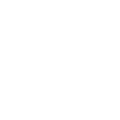

In [20]:
with open('./test/html/09-tokopedia.html') as file:
    print(json.dumps(extract(file.read()), indent=2))

In [21]:
with open('./test/html/10-entercomputer.html') as file:
    print(json.dumps(extract(file.read()), indent=2))

{
  "authors": [],
  "banner": "https://www.enterkomputer.com/web-assets/frontend/meta-image/EK_metaimage-3.png",
  "codes": [],
  "content": "",
  "description": "Welcome to EnterKomputer - Buka Setiap Hari, 10:00-18:00 WIB",
  "date": "None",
  "images": [
    {
      "title": "footer-image.webp",
      "domain": "enterkomputer.com",
      "url": "https://www.enterkomputer.com/assets/img/webp/footer-image.webp"
    },
    {
      "title": "EK-circle-logo.png",
      "domain": "d1edrlpyc25xu0.cloudfront.net",
      "url": "https://d1edrlpyc25xu0.cloudfront.net/tomep-s0gj2b3ekbqqti9/image/upload/wmzhOvuJVz/EK-circle-logo.png"
    },
    {
      "title": "circle-logo.png",
      "domain": "enterkomputer.com",
      "url": "https://www.enterkomputer.com/assets/img/logo/circle-logo.png"
    },
    {
      "title": "9477422c-9588-4c35-8dfc-710a591fddb7.jpg",
      "domain": "images.tokopedia.net",
      "url": "https://images.tokopedia.net/img/cache/300/VqbcmM/2022/8/19/9477422c-9588-4c35-